In [1]:
import fastf1 as ff1
from fastf1 import plotting

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from matplotlib.patches import Rectangle, Polygon
import matplotlib.image as mpimg

import numpy as np
import re

from matplotlib.image import imread
from PIL import Image

In [2]:
ff1.Cache.enable_cache('../cache')
pd.options.mode.chained_assignment = None

In [3]:
year, event, event_type = 2023, 'Australia', 'R'
session = ff1.get_session(year, event, event_type)
laps = session.load_laps()

C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)

In [4]:
# Convert laptimes to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# To get accurate laps only, we exclude in- and outlaps
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [5]:
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [6]:
drivers_to_visualize = ['VER', 'HAM', 'ALO', 'STR', 'PER', 'NOR', 'HUL', 'PIA', 'ZHO']
# drivers_to_visualize = ['VER', 'PER', 'RUS', 'HAM', 'ALO', 'STR', 'SAI', 'LEC', 'GAS', 'OCO', 'BOT', 'ZHO', 'HUL', 'MAG', 'SAR', 'ALB', 'TSU', 'DEV', 'NOR', 'PIA']
#drivers_to_visualize = ['VER', 'PER', 'HAM', 'ALO', 'STR', 'SAI', 'GAS', 'OCO', 'BOT', 'ZHO', 'HUL', 'MAG', 'SAR', 'TSU', 'DEV', 'NOR', 'PIA']

In [7]:
plot_width = 10
plot_height = 10
plot_size = [plot_width, plot_height]
title_font_size = int(2 * plot_height)  # Adjust the 0.15 multiplier to your liking
axis_label_font_size = int(1.5 * plot_height)  # Adjust the 0.1 multiplier to your liking
autolayout = True
# plot_title = f"{session.event.year} {session.event.EventName} - Race Pace \n Top Three Teams & Drivers Analysis"
plot_title = f"{session.event.year} {session.event.EventName} - Race Pace Analysis Top Ten"
# plot_ratios = [7,7]
plot_filename = re.sub(r'\W+', '', plot_title.replace("\n", " ")) + ".png"
logo_path = '../RCKMG_logo.png'
logo_img = Image.open(logo_path)

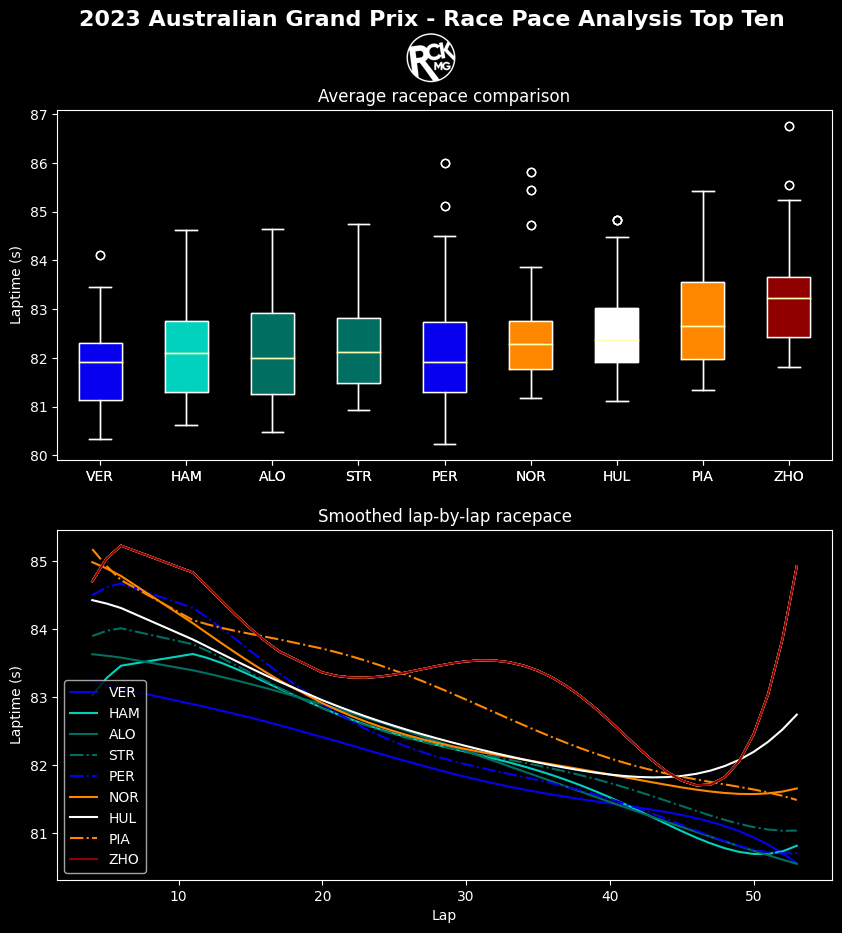

In [23]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size
plt.style.use('dark_background')

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)
fig.suptitle(plot_title, fontsize=16, fontweight='bold')
##############################
# Boxplot for average racepace
##############################
laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize)

ax[0].set_title('Average racepace comparison')
ax[0].set(ylabel = 'Laptime (s)')




##############################
# Lap-by-lap racepace comparison
##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else 'dashdot'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    # Include scatterplot (individual laptimes)
    # y = driver_laps['LapTimeSeconds']
    # scatter_marker = 'o' if team not in visualized_teams else '^' 
    # ax[1].scatter(x, y, label=driver, color=ff1.plotting.team_color(team), marker=scatter_marker)
    
    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')
    
    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace')

    # Generate legend
    ax[1].legend()
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

    # Create a dictionary to store the team colors for each driver
team_colors = {driver: ff1.plotting.team_color(pd.unique(laps.pick_driver(driver)['Team'])[0]) for driver in drivers_to_visualize}

# Boxplot for average racepace
box = ax[0].boxplot(laptimes, labels=drivers_to_visualize, patch_artist=True)

# Color the boxplots
for patch, driver in zip(box['boxes'], drivers_to_visualize):
    patch.set_facecolor(team_colors[driver])

    
# Define the new width and height for the logo
new_width = 50
new_height = 50
# Resize the logo
logo_resized = logo_img.resize((new_width, new_height))
logo_resized_np = np.array(logo_resized)
logo_x = 406
logo_y = 850
fig.figimage(logo_resized_np, xo=logo_x, yo=logo_y, zorder=1, origin='upper', alpha=1)
# Your other code for setting titles, labels, etc., goes here

# Lap-by-lap racepace comparison
for driver in drivers_to_visualize:
    # Your existing code for plotting the lap-by-lap race pace

    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=team_colors[driver], linestyle=linestyle)

# plt.savefig(plot_filename, dpi=300)
plt.show()